In [ ]:
#Input Values (or import values via PaperMill)
b0 = 0.35
h0 = 0.35
t0= 0.02
b1 = 0.3
h1 = 0.3
t1 = 0.016

e = -0.11
chordspacing = 2.0
L_chord = 6
div_chord = 4

P_chord = 100000
P_brace = 50000
M_ip_chord = 10000
M_op_chord = 10000
M_op_brace = 10000

deltaF = 24300000

SCF_ch_op = 2.0
SCF_br_op = 2.0

name1 = "Truss 1"
name2 = "K-joint"
loadcase = "Fatigue"
location = "Support 1"
name = "John Smith"

In [ ]:
from math import sqrt, cos, sin, pi, atan, tan
import matplotlib.pyplot as plt
import sectionproperties.pre.sections as sections
from sectionproperties.analysis.cross_section import CrossSection
import csv
import pprint
import handcalcs.render
from handcalcs import handcalc
import forallpeople
forallpeople.environment('structural',top_level=True)
import datetime

In [ ]:
%%render
name1
name2
loadcase
location
name

In [ ]:
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
def pass_fail(value,lessthan=None,greaterthan=None):
    passing = True
    if lessthan is not None:
        print(f'Check {value:.2f} <= {lessthan}')
        if value > lessthan:
            passing = False
        if value >= 0 and lessthan >= 0:
            print(f'Util = {value/lessthan:.2f}')
    if greaterthan is not None:
        print(f'Check {value:.2f} >= {greaterthan}')
        if value < greaterthan:
            passing = False
        if value >= 0 and greaterthan >= 0:
            print(f'Util = {greaterthan/value:.2f}')
    if passing:
        print("\x1b[32mPASS\x1b[0m")
    else:        
        print("\x1b[31mFAIL\x1b[0m")

# <font color = blue> Uniplanar SHS/RHS K-Joints with Overlap </font>
## <font color = blue> CIDECT DESIGN GUIDE 8 </font>

The purpose of this worksheet is to determine the allowable stresses at the K-Joints of the trusses.

The CIDECT 8 design guide is adopted. It can be downloaded at:
[https://www.cidect.org/design-guides/](https://www.cidect.org/design-guides/)

# <font color = red> INPUT GEOMETRY </font>

[Excerpt 1: Notation](#ex1_notation)


## Chord Size

In [ ]:
%%render 1
b0 = (b0*m) #Width of Chord
h0 = (h0*m) #Height of Chord
t0 = (t0*m) #Thickness of Chord

## Brace size

In [ ]:
%%render 1
b1 = (b1*m) #Width of Brace
h1 = (h1*m) #Height of Brace
t1 = (t1*m) #Thickness of Brace

## Parameters to determine Brace Angle

In [ ]:
%%render
e = (e*m) #Eccentricity
chordspacing = (chordspacing*m) #Spacing between Legs for determining brace angle
L_chord = (L_chord*m) #Height of legs for determining brace angle
div_chord #no diagonal braces for determining brace angle

# <font color = red> INPUT LOADING </font>

[Excerpt 2: Load Conditions](#ex2_loadconditions)

In [ ]:
%%render
P_chord = (P_chord*N) #Axial Force +ve Compression
P_brace = (P_brace*N) #Axial Force +ve Tension
M_ip_chord = (M_ip_chord*Nm) #Moment In-Plane on Chord (Column of Gantry)
M_op_chord = (M_op_chord*Nm) #Moment Out-of-Plane on Chord (Column of Gantry)
M_op_brace = (M_op_brace*Nm) #Moment Out-of-Plane on Brace (Between gantry columns)

# <font color = red> CAPACITY </font>

In [ ]:
%%render
deltaF = deltaF*Pa #Allowable fatigue stress after SCF applied

# <font color = red> SCF ASSUMED </font>
CIDECT 8 does not cover out of plane bending of SHS/RHS sections.

Out of plane SCF's are defined manually below.

In [ ]:
%%render
SCF_ch_op #Min recommended Sec 5 and Appendix C
SCF_br_op #Min recommended Sec 5 and Appendix C

## <font color = blue> Parameters </font>

In [ ]:
%%render 1
beta = b1 / b0 #Ratio of brace to chord width, where 0.35 <= beta <= 1.0
gamma = b0 / (2 * t0) #Ratio of chord width to 2*thickness, where 10 <= 2*omega <= 35
tau = t1 / t0 #Ratio of brace to chord thickness, where 0.25 < tau <= 1.0

### <font color = blue> Truss Overlap Calculations</font>
Determine bracing centreline length between intersection points

[Excerpt 3: Overlap Calculation](#ex3_overlapcalculation)

In [ ]:
%%render long
h_truss = chordspacing + 2 * e #Height of truss adjusted by eccentricity.
l_truss = L_chord / div_chord #Length of truss (projection of brace onto the chord)
theta = atan(h_truss / l_truss) #Angle between chord and brace

In [ ]:
%%render
p = h1 / sin(theta) #Projected width of brace
x = (0.5*h0 + e) / tan(theta) #Projection of Intersection
q = p - 2 * x #Overlap Projection
Ov = q / p #Overlap, where 50% <= Ov <= 100%

## <font color = blue> Check Parameter within Allowable </font>

In [ ]:
print('beta:')
pass_fail(beta,1,0.35)
print('\n2*gamma:')
pass_fail(2*gamma,35,10)
print('\ntau:')
pass_fail(tau,1.0,0.35)

In [ ]:
print('theta:')
pass_fail(theta*180/pi,60,30)
print('\nOv:')
pass_fail(Ov,1.0,0.5)
print('\ne/h0:')
pass_fail(e/h0,lessthan = 0.25,greaterthan = -0.55)

# <font color = blue> Section Properties </font>

The following section calculates the SHS properties:

- 2nd moment of area in 2 directions.
- area

This is to enable determining the external fibre stresses:

In [ ]:
#Class to define SHS Object and allow operations such as analyse geometry
class shs:
    def __init__(self,d,b,t,r_out):
        self.d = d
        self.b = b
        self.t = t
        self.r_out = r_out

    def anal(self,n_r,mesh_sizes):
        geometry = sections.Rhs(d=self.d, b=self.b, t=self.t, r_out=self.r_out, n_r=n_r)
        mesh = geometry.create_mesh(mesh_sizes=[mesh_sizes])
        section = CrossSection(geometry, mesh)
        geometry.plot_geometry()
        section.calculate_geometric_properties()
        self.area = section.get_area()
        (self.ixx, self.iyy, self.ixy) = section.get_ic()

In [ ]:
#Define SHS Chord
print('The cross sectional properties of the chord member:')
chord = shs(h0.value,b0.value,t0.value,2.5 * t0.value)
chord.anal(8,t0.value**2)
print(f'SHS chord:\nArea={chord.area:6.2e} m^2\nIxx={chord.ixx:6.2e} m^4\n'
      f'Iyy={chord.iyy:6.2e} m^4')

In [ ]:
#Define SHS Bracing
print('The cross sectional properties of the bracing member:')
brace = shs(h1.value,b1.value,t1.value,2.5 * t1.value)
brace.anal(8,t1.value**2)
print(f'SHS Brace:\nArea={brace.area:6.2e} m^2\nIxx={brace.ixx:6.2e} m^4\n'
    f'Iyy={brace.iyy:6.2e} m^4')


# <font color = blue> SCF Calculations </font>

The follow calculations determine the Stress Concentration Factors (SCF) for each:
- LC1 chord -> $SCF_{ch,ax}$
- LC1 brace -> $SCF_{b,ax}$
- LC2 chord -> $SCF_{ch,ch}$

[Excerpt 4: E.3 SCF Locations](#ex4_SCFlocations)

## $SCF_{chax}$ Calculation

In [ ]:
%%render long
#Loop all calculations
SCF_chaxpt1 = (0.5+ 2.38 * beta - 2.87 * beta**2 + 2.18 * beta * Ov + 0.39 * Ov - 1.43 * sin(theta))
SCF_chaxpt2 =  ((2 * gamma)**0.29 * tau**0.7 * Ov**(0.73-5.53*sin(theta)**2) * sin(theta)**(-0.4-0.08*Ov))
SCF_chax = SCF_chaxpt1 * SCF_chaxpt2 #Balanced Loading condition Chord Forces

## $SCF_{bax}$ Calculation

In [ ]:
%%render long
SCF_baxpt1 = 0.15 + 1.1 * beta - 0.48 * beta**2 - 0.14 / Ov
SCF_baxpt2 = (2 * gamma)**0.55 * tau**(-0.3) * Ov**(-2.57 + 1.62 * beta**2) * sin(theta)**0.31
SCF_bax = SCF_baxpt1 * SCF_baxpt2 #Balanced Loading condition Brace Forces

## $SCF_{chch}$ Calculation

In [ ]:
%%render long
SCF_chch = 1.2 + 1.46 * beta - 0.028 * beta**2

# <font color = blue> 3.3 Nominal Stress Ranges </font>

Nominal stresses are obtained by getting the principal and outer fiber bending stresses of each element defined in Sec 3.3.

## $\sigma_{chord}$
## Balanced LC

In [ ]:
%%render long
sigma_chord1P = SCF_chax * (P_brace * cos(theta)) / (chord.area * m**2)

## Unbalanced LC

In [ ]:
%%render
sigma_chord2P = SCF_chch * (P_chord - P_brace * cos(theta))/ (chord.area * m**2)

## Bending Moment

In [ ]:
%%render
y_ip_chord = h0/2 #Dist from NA to top/bottom of brace
y_op_chord = (b0-b1)/2 #Dist from NA to left/right of brace

In [ ]:
%%render long
sigma_chordM_ip = SCF_chch * (M_ip_chord * y_ip_chord) / (chord.ixx * m**4)
sigma_chordM_op = SCF_ch_op * (M_op_chord * y_op_chord) / (chord.iyy * m**4)

## Chord Total

In [ ]:
%%render long 1
sigma_chord = sigma_chord1P + sigma_chord2P + sigma_chordM_ip + sigma_chordM_op

In [ ]:
print('Sigma_chord capacity:')
pass_fail(sigma_chord.value,lessthan = deltaF.value)

##  <font color = blue> Brace Stresses </font>
## $\sigma_{brace}$
## Balanced LC

In [ ]:
%%render long
sigma_braceP = SCF_bax * P_brace / (brace.area * m**2)

## Bending Moment

In [ ]:
%%render
z_op_brace = b1/2
sigma_braceM_op = SCF_br_op * M_op_brace * z_op_brace / (brace.iyy * m**4)

## Brace Total

In [ ]:
%%render long
sigma_brace = sigma_braceP + sigma_braceM_op

In [ ]:
print('Sigma_brace capacity:')
pass_fail(sigma_brace.value,lessthan = deltaF.value)

#  <font color = blue> RELEVANT CLAUSES </font>


<a id='ex1_notation'></a>

### Excerpt 1: Notation

<div>
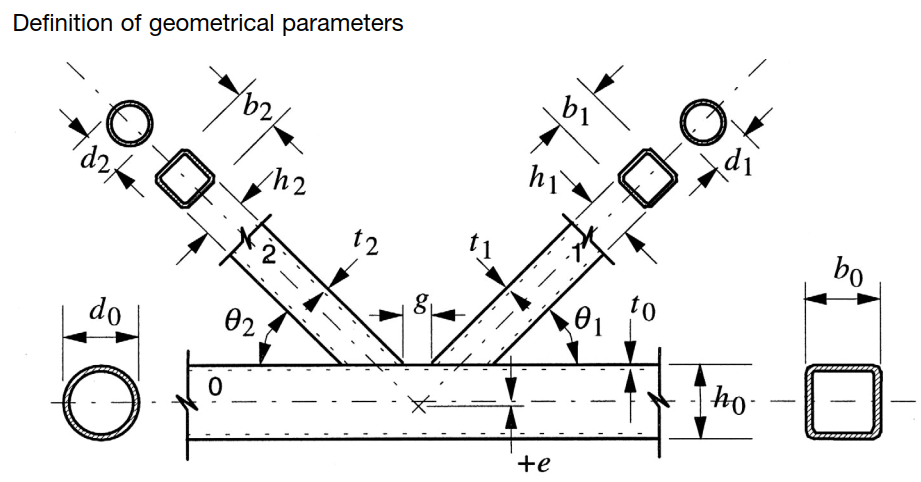
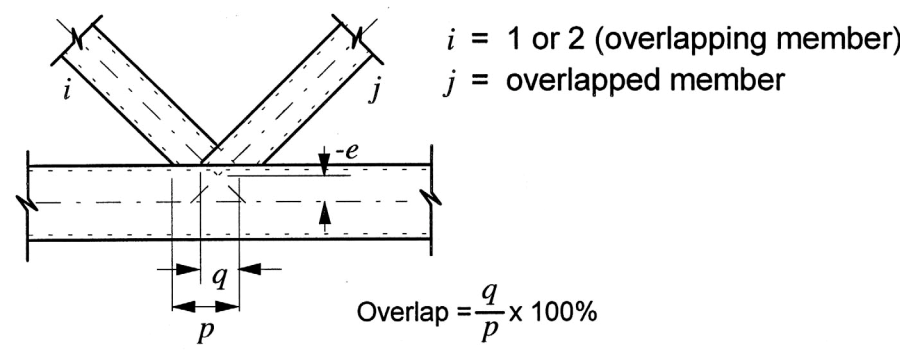
</div>

<a id='ex2_loadconditions'></a>

### Excerpt 2: Load Conditions
<div>
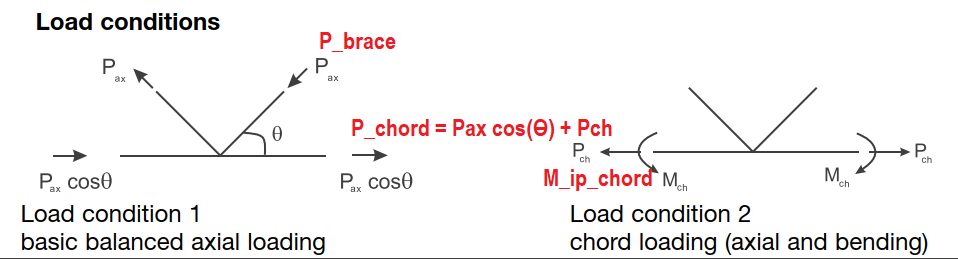
</div>

<a id='ex3_overlapcalculation'></a>

### Excerpt 3: Overlap Calculation
<div>
<img src = attachment:truss_overlap.PNG width = 700 />
</div>
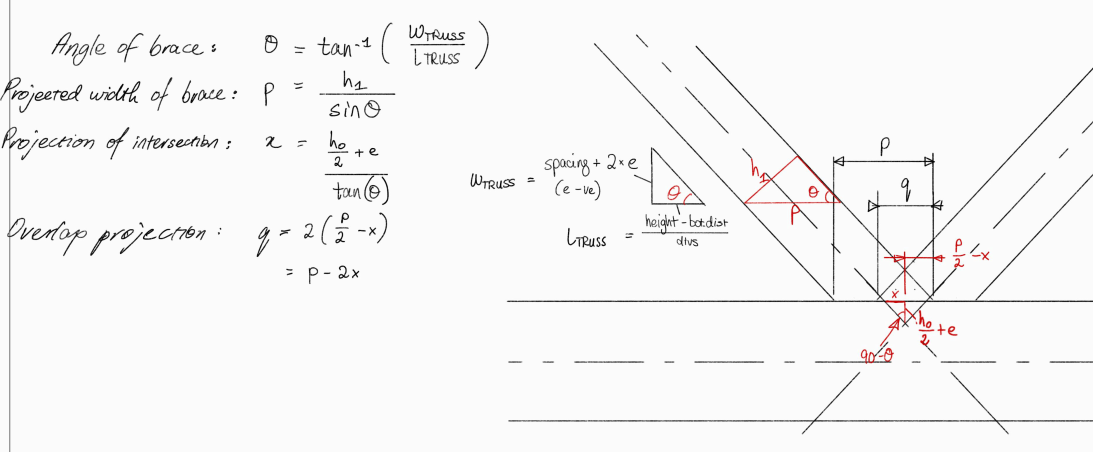

<a id='ex4_SCFlocations'></a>

### Excerpt 4: E.3 SCF Locations

<div>
    <img src = attachment:SCF_locs.PNG width = 500 />
    </div>
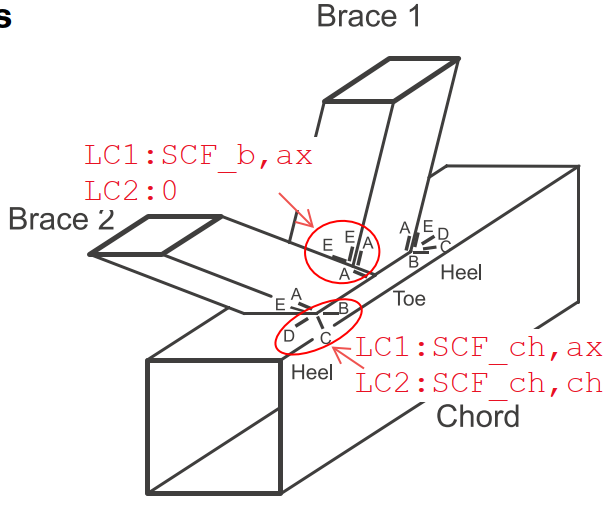

#  <font color = blue> SUMMARY </font>

## Geometry Check Summary

In [ ]:
print('beta:')
pass_fail(beta,1,0.35)
print('\n2*gamma:')
pass_fail(2*gamma,35,10)
print('\ntau:')
pass_fail(tau,1.0,0.35)
print('\ntheta:')
pass_fail(theta * 180/pi,60,30)
print('\nOv:')
pass_fail(Ov,1.0,0.5)
print('\ne/h0:')
pass_fail(e/h0,lessthan = 0.25,greaterthan = -0.55)

## Stress Check Summary

In [ ]:
print('\nSigma_chord capacity:')
pass_fail(sigma_chord.value,lessthan = deltaF.value)
print('\nSigma_brace capacity:')
pass_fail(sigma_brace.value,lessthan = deltaF.value)